In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [51]:
transformers=transforms.Compose([transforms.ToTensor()])
def data_load(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(
                            datasets.MNIST(root='data',train=True,download=True, transform=transformers),
                            batch_size=train_batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
                            datasets.MNIST(root='data',train=False,download=True, transform= transformers),
                            batch_size=test_batch_size, shuffle=True)
    
    return (train_loader,test_loader)

In [52]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 16)
        self.fc2 = nn.Linear(16, 14)
        self.fc3 = nn.Linear(14, 10)
    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [53]:
def evaluate_model(data, data_loader, criterion):
    
    total_samples, correct_preds = 0, 0
    cumulative_loss, batches = 0.0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            # reshape 28x28 images into 784-dim vectors
            inputs = images.view(images.size(0), -1)

            outputs = data(inputs)
            loss = criterion(outputs, labels)

            cumulative_loss += loss.item()
            batches += 1

            # compute accuracy
            predicted = outputs.argmax(dim=1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = cumulative_loss / batches
    accuracy = round(correct_preds / total_samples, 3)
    return avg_loss, accuracy

In [54]:
def train_model(data, train_loader, test_loader, criterion, optimizer, epochs):
    history = pd.DataFrame()

    for epoch in range(epochs):
        data.train()
        for images, labels in train_loader:
            inputs = images.view(images.size(0), -1)

            optimizer.zero_grad()
            outputs = data(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # log weights for PCA tracking
        weights_df = pd.DataFrame()
        for name, param in data.named_parameters():
            if "weight" in name:
                w_flat = param.detach().cpu().numpy().ravel()
                weights_df = pd.concat([weights_df, pd.DataFrame([w_flat])], axis=1)
        history = pd.concat([history, weights_df], axis=0)

        # check performance
        train_loss, train_acc = evaluate_model(data, train_loader, criterion)
        test_loss, test_acc = evaluate_model(data, test_loader, criterion)

        train_loss_array.append(train_loss)
        test_loss_array.append(test_loss)
        train_acc_array.append(train_acc)
        test_acc_array.append(test_acc)

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}")

    return history

In [55]:
# Load data
train_data, test_data = data_load(1000, 1000)

criterion = nn.CrossEntropyLoss()
total_w_df = pd.DataFrame()
total_train_loss, total_test_loss = [], []
total_train_acc, total_test_acc = [], []

for i in range(8):
    print(f"Training loop - {i+1}")
    
    # Initialize model + optimizer
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Reset arrays for this run
    train_loss_array, test_loss_array = [], []
    train_acc_array, test_acc_array = [], []
    
    # Train and evaluate
    w_df = train_model(
        data=model,
        train_loader=train_data,
        test_loader=test_data,
        criterion=criterion,
        optimizer=optimizer,
        epochs=32
    )
    
    # Append history
    total_train_loss.extend(train_loss_array)
    total_test_loss.extend(test_loss_array)
    total_train_acc.extend(train_acc_array)
    total_test_acc.extend(test_acc_array)
    
    # Collect weights
    total_w_df = pd.concat([total_w_df, w_df], axis=0)

# Final results
print("Training completed for all runs.")

Training loop - 1
[Epoch 1/32] Train Loss=0.3705, Train Acc=0.892 | Test Loss=0.3701, Test Acc=0.895
[Epoch 2/32] Train Loss=0.2533, Train Acc=0.929 | Test Loss=0.2551, Test Acc=0.927
[Epoch 3/32] Train Loss=0.2129, Train Acc=0.938 | Test Loss=0.2231, Test Acc=0.935
[Epoch 4/32] Train Loss=0.1918, Train Acc=0.944 | Test Loss=0.2061, Test Acc=0.939
[Epoch 5/32] Train Loss=0.1782, Train Acc=0.948 | Test Loss=0.1976, Test Acc=0.940
[Epoch 6/32] Train Loss=0.1579, Train Acc=0.953 | Test Loss=0.1836, Test Acc=0.946
[Epoch 7/32] Train Loss=0.1461, Train Acc=0.957 | Test Loss=0.1741, Test Acc=0.949
[Epoch 8/32] Train Loss=0.1419, Train Acc=0.958 | Test Loss=0.1719, Test Acc=0.950
[Epoch 9/32] Train Loss=0.1338, Train Acc=0.961 | Test Loss=0.1669, Test Acc=0.950
[Epoch 10/32] Train Loss=0.1383, Train Acc=0.958 | Test Loss=0.1722, Test Acc=0.949
[Epoch 11/32] Train Loss=0.1234, Train Acc=0.963 | Test Loss=0.1608, Test Acc=0.952
[Epoch 12/32] Train Loss=0.1150, Train Acc=0.965 | Test Loss=0.1588

In [62]:
# Collect all weights for PCA
all_df = total_w_df.copy()
all_weights_array = all_df.to_numpy()
pca = PCA(n_components=2)
pca_data = pca.fit_transform(all_weights_array)

# Create final DataFrame with PCA coordinates
final_df = pd.DataFrame(pca_data, columns=['x', 'y'])
final_df['Accuracy'] = total_train_acc[:len(final_df)]
final_df['Loss'] = total_train_loss[:len(final_df)]
final_df = final_df.iloc[::3, :].reset_index(drop=True)

print(final_df.head())

           x          y  Accuracy      Loss
0  -4.770985  -5.100584     0.892  0.370549
1 -10.207552  -9.501121     0.944  0.191801
2 -14.203757 -13.019098     0.957  0.146050
3 -17.521578 -16.260633     0.958  0.138348
4 -20.412769 -18.978868     0.965  0.114277


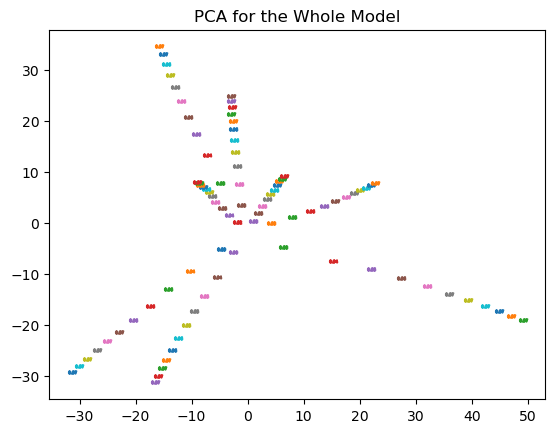

In [63]:
for i in range(len(final_df)):
    m = final_df['Accuracy'].iloc[i]   # get Accuracy by position
    x = final_df['x'].iloc[i]
    y = final_df['y'].iloc[i]
    plt.scatter(x, y, marker=f'${m:.2f}$')
plt.title("PCA for the Whole Model")
plt.show()

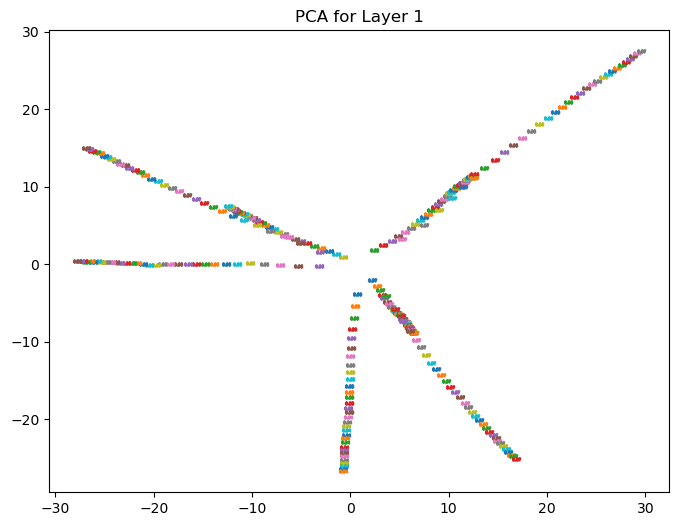

In [64]:
# Select weights for layer 1
layer_1_data = all_df.iloc[:, :7000]
layer_1_pca = PCA(n_components=2)
layer_1_new_data = layer_1_pca.fit_transform(layer_1_data)
layer_1_df = pd.DataFrame(layer_1_new_data, columns=['x', 'y'])
repeats = len(layer_1_df) // len(train_acc_array)
layer_1_df['Accuracy'] = np.repeat(train_acc_array, repeats)[:len(layer_1_df)]
layer_1_df['Loss'] = np.repeat(train_loss_array, repeats)[:len(layer_1_df)]
# Plot PCA with Accuracy as marker label
plt.figure(figsize=(8, 6))
for i in range(len(layer_1_df)):
    m = layer_1_df['Accuracy'].iloc[i]
    x = layer_1_df['x'].iloc[i]
    y = layer_1_df['y'].iloc[i]
    plt.scatter(x, y, marker=f'${m:.2f}$') 
plt.title("PCA for Layer 1")
plt.show()

In [65]:
ip = np.expand_dims(np.arange(-1.5, 1.5, 0.01),1)
op = (np.sin(5 * np.pi * ip))
x = torch.tensor(ip, dtype=torch.float32)
y = torch.tensor(op, dtype=torch.float32)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 10)
        self.linear_4 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)
    
    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear_1(x))
        x = nn.functional.leaky_relu(self.linear_2(x))
        x = nn.functional.leaky_relu(self.linear_3(x))
        x = nn.functional.leaky_relu(self.linear_4(x))
        x = self.predict(x)
        return x

In [66]:
def train_model(model, x, y):
    epoch_size = 4000
    losses_arr = []
    epochs_arr = []
    grad_arr = []
    converged = False
    for epoch in range(epoch_size):
        if converged:
            return epochs_arr, losses_arr, y_prediction, grad_arr

        y_prediction = model(x)
        loss = loss_func(y_prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epochs_arr.append(epoch)
        losses_arr.append(loss.detach().numpy())
        
        # Calculate gradient norm
        grad_all = 0.0
        for p in model.parameters():
            if p.grad is not None:
                grad_all += (p.grad.detach().cpu().numpy() ** 2).sum()
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)
        
        if epoch % 400 == 0: 
            print(f'epoch: {epoch}, loss = {loss.item():.4f}')
            
        # Convergence check
        if (epoch > 5) and (losses_arr[-1] < 0.01):
            if abs(losses_arr[-3] - losses_arr[-2]) < 1.0e-05 and abs(losses_arr[-2] - losses_arr[-1]) < 1.0e-05:
                print("Convergence reached for loss:", losses_arr[-1])
                converged = True
                
    return epochs_arr, losses_arr, y_prediction, grad_arr

In [67]:
model = Model()
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs_arr, losses_arr, prediction, grad_arr = train_model(model, x, y)

epoch: 0, loss = 0.5056
epoch: 400, loss = 0.4996
epoch: 800, loss = 0.4863
epoch: 1200, loss = 0.4750
epoch: 1600, loss = 0.4747
epoch: 2000, loss = 0.4746
epoch: 2400, loss = 0.4746
epoch: 2800, loss = 0.4746
epoch: 3200, loss = 0.4714
epoch: 3600, loss = 0.4573


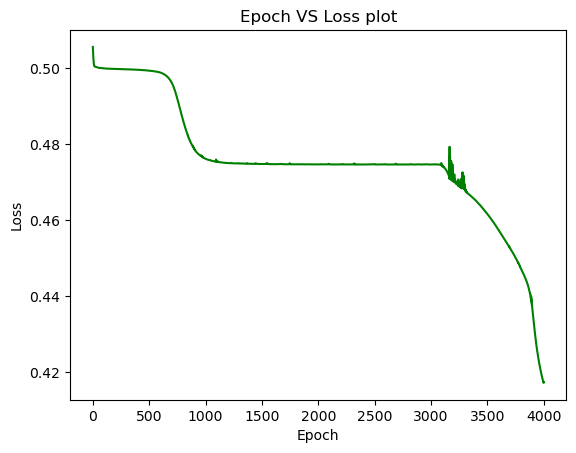

In [68]:
plt.plot(epochs_arr, losses_arr, color = "green")
plt.title('Epoch VS Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

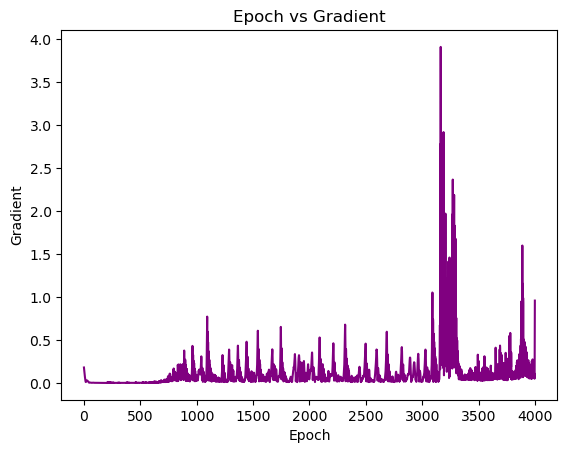

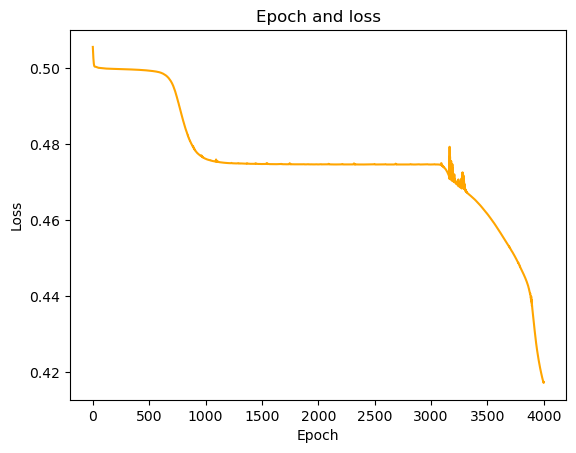

In [69]:
plt.plot(epochs_arr, grad_arr, color = "purple")
plt.title('Epoch vs Gradient')
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.show()

plt.plot(epochs_arr, losses_arr, color = "orange")
plt.title('Epoch and loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()